In [9]:
import numpy as np
import matplotlib.pyplot as plt

from roboticstoolbox import models
import roboticstoolbox as rtb

In [10]:
# Загрузка модели UR5
robot = models.DH.UR5()

# Вывод DH-параметров
print("Параметры Денавита-Хартенберга:")
for i in range(len(robot.links)):
    print(f"Звено {i}: {robot.links[i]}")

Параметры Денавита-Хартенберга:
Звено 0: RevoluteDH:   θ=q,  d=0.089459,  a=0,  ⍺=1.5707963267948966
Звено 1: RevoluteDH:   θ=q,  d=0,  a=-0.425,  ⍺=0.0
Звено 2: RevoluteDH:   θ=q,  d=0,  a=-0.39225,  ⍺=0.0
Звено 3: RevoluteDH:   θ=q,  d=0.10915,  a=0,  ⍺=1.5707963267948966
Звено 4: RevoluteDH:   θ=q,  d=0.09465,  a=0,  ⍺=-1.5707963267948966
Звено 5: RevoluteDH:   θ=q,  d=0.0823,  a=0,  ⍺=0.0


In [11]:
# Массы звеньев (кг)
masses = [3.7, 6.8, 4.8, 0.8, 0.8, 0.8]

# Центр масс каждого звена (в локальной системе координат)
centers_of_mass = [
    [0, 0, -0.08],   # Звено 1
    [0, -0.12, 0],   # Звено 2
    [0, 0, -0.12],   # Звено 3
    [0, 0, 0],       # Звено 4
    [0, 0, 0],       # Звено 5
    [0, 0, 0]        # Звено 6
]

# Тензоры инерции (Lxx, Lyy, Lzz, Lxy, Lyz, Lxz)
inertias = [
    [0.0, 0.09, 0.09, 0, 0, 0],         # Звено 1
    [0.23, 0.2, 0.03, 0, 0, 0],         # Звено 2
    [0.02, 0.02, 0.03, 0, 0, 0],        # Звено 3
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 4
    [0.001, 0.001, 0.001, 0, 0, 0],     # Звено 5
    [0.001, 0.001, 0.001, 0, 0, 0]      # Звено 6
]

# Момент инерции двигателей (примерно)
Jm = [0.0001, 0.0004, 0.0001, 0.00001, 0.00001, 0.00001]

# Коэффициенты вязкого трения
B = [0.1, 0.1, 0.05, 0.01, 0.01, 0.01]

# Коэффициенты кулоновского трения (±)
Tc = [0.3, 0.5, 0.3, 0.1, 0.1, 0.1]

# Передаточные числа редукторов
G = [100, 100, 100, 50, 50, 50]

# Ограничения по обобщенным координатам (радианы)
qlim = [
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi],
    [-np.pi, np.pi]
]

# Присвоение динамических параметров каждому звену
for i in range(6):
    robot.links[i].m = masses[i]
    robot.links[i].r = centers_of_mass[i]
    robot.links[i].I = inertias[i]
    robot.links[i].Jm = Jm[i]
    robot.links[i].B = B[i]
    robot.links[i].Tc = Tc[i]
    robot.links[i].G = G[i]
    robot.links[i].qlim = qlim[i]

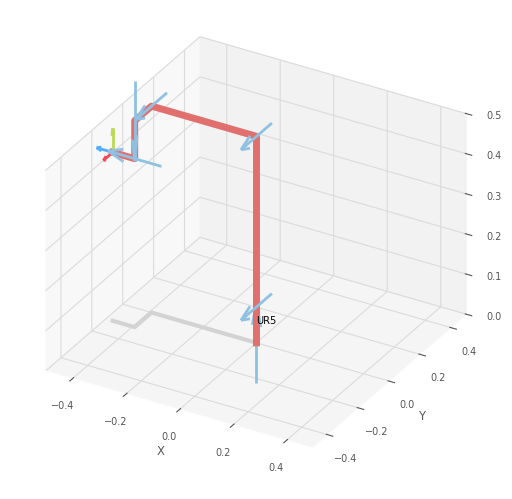

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5')

<Figure size 640x480 with 0 Axes>

In [12]:
# Произвольная начальная конфигурация
q_start = np.array([0, -np.pi / 2, np.pi / 2, 0, np.pi / 2, 0])

# Визуализация начальной конфигурации
robot.plot(q_start, backend='pyplot', block=False, limits=[-0.5, 0.5, -0.5, 0.5, 0, 0.5])

In [13]:
# Решение прямой задачи кинематики

T = robot.fkine(q_start) 
T

   0         0        -1        -0.4745    
  -1         0         0        -0.1091    
   0         1         0         0.4198    
   0         0         0         1         


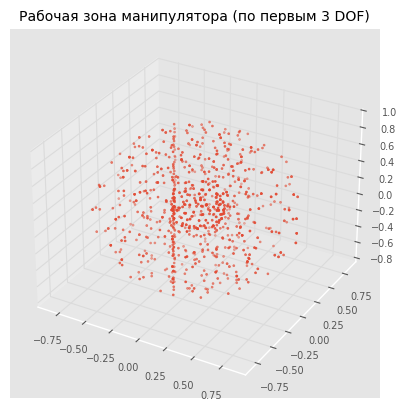

In [21]:
# Рабочая зона манипулятора при заданных ограничения

x, y, z = [], [], []
angles = np.linspace(-np.pi, np.pi, 10)

for q1 in angles:
    for q2 in angles:
        for q3 in angles:
            q = [q1, q2, q3, 0, 0, 0]
            try:
                pos = robot.fkine(q).t
                x.append(pos[0])
                y.append(pos[1])
                z.append(pos[2])
            except:
                continue

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, s=2)
ax.set_title("Рабочая зона манипулятора (по первым 3 DOF)")
plt.show()


In [17]:
# конечная точка и решение задачи обратной кинематики
q_end = np.array([np.pi/2, -np.pi/3, np.pi/3, 0, np.pi/2, 0])
T = robot.fkine(q_end) 
q = robot.ikine_GN(T, q0=q_start).q
q

array([-1.21366553e+00, -3.09532809e+00,  1.04719753e+00,  2.04813041e+00,
       -1.21366553e+00,  2.46229851e-07])

In [39]:
# Планирование траектории 

timesteps = 50
time = np.linspace(0, 5, timesteps)

# 1. Трапециодальная 
tr_1 = rtb.mtraj(rtb.trapezoidal, q_start, q_end, time)

# 2. Квинтическая
tr_2 = rtb.mtraj(rtb.quintic, q_start, q_end, time)

# 3. Полиномиальная
tr_3 = rtb.mtraj(rtb.jtraj, q_start, q_end, time)


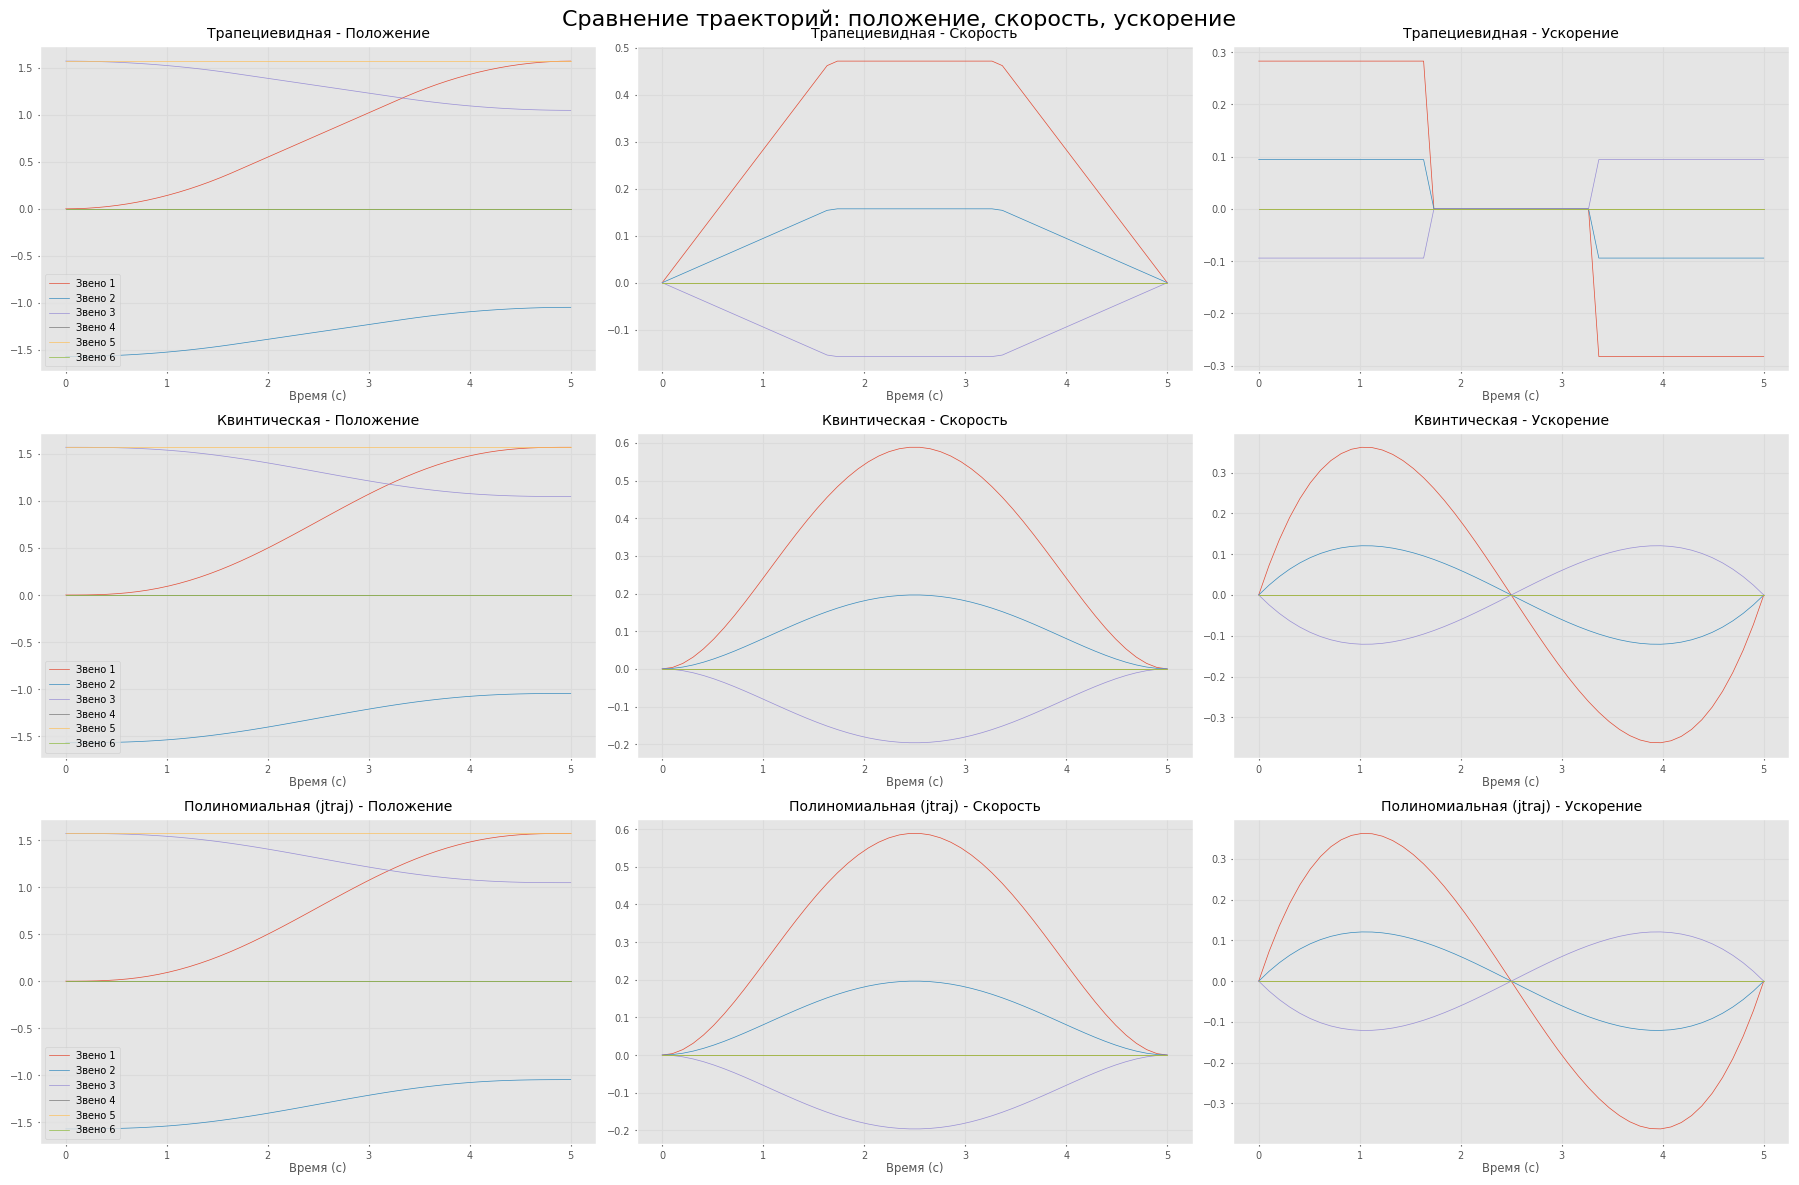

In [40]:
# Создаем графики
fig, axs = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('Сравнение траекторий: положение, скорость, ускорение', fontsize=16)

# Функция для построения графиков
def plot_trajectory(ax_row, q, qd, qdd, title):
    for i in range(6):
        ax_row[0].plot(time, q[:, i], label=f'Звено {i+1}')
        ax_row[1].plot(time, qd[:, i])
        ax_row[2].plot(time, qdd[:, i])
    
    ax_row[0].set_title(f'{title} - Положение')
    ax_row[1].set_title(f'{title} - Скорость')
    ax_row[2].set_title(f'{title} - Ускорение')
    
    for ax in ax_row:
        ax.set_xlabel('Время (с)')
        ax.grid(True)
    ax_row[0].legend()

# Трапециевидная
plot_trajectory(axs[0], tr_1.q, tr_1.qd, tr_1.qdd, 'Трапециевидная')

# Квинтическая
plot_trajectory(axs[1], tr_2.q, tr_2.qd, tr_2.qdd, 'Квинтическая')

# Полиномиальная (jtraj)
plot_trajectory(axs[2], tr_3.q.reshape(tr_2.q.shape), tr_3.qd.reshape(tr_2.qd.shape), tr_3.qdd.reshape(tr_2.qdd.shape), 'Полиномиальная (jtraj)')

plt.tight_layout()
plt.show()